In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Colab 폴더로 경로 이동
%cd /content/drive/MyDrive/Colab Notebooks/DeepLearning

/content/drive/MyDrive/Colab Notebooks/DeepLearning


# 3D 숫자 분류 [2조 신민수]
- '3D_MNIST' 
- 자료 출처:https://www.kaggle.com/datasets/daavoo/3d-mnist
---
### [1] 데이터 준비



In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.utils import set_random_seed, plot_model
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

import seaborn as sns
import os
import h5py

In [ ]:
set_random_seed(42)

In [ ]:
with h5py.File('../Kaggle/3D_MNIST/full_dataset_vectors.h5', "r") as hf:    
    # Split the data into training/test features/targets
    x_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    x_test = hf["X_test"][:] 
    y_test = hf["y_test"][:]

print(f'x_train_shape: {x_train.shape}, y_train_shape: {y_train.shape}')
print(f'x_test_shape : {x_test.shape},  y_test_shape : {y_test.shape}')

x_train_shape: (10000, 4096), y_train_shape: (10000,)
x_test_shape : (2000, 4096),  y_test_shape : (2000,)


In [ ]:
y_train[1], y_test[1]

(5, 7)

# [2] 차원변환 
---
- channel dimention 추가
- rgb dimention 추가
- 1+ 4D space로 변환
- target 원핫인코딩

In [ ]:
## 데이터셋 channel 추가 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

# rgb
def add_rgb_dimention(array):
    scalar_map = cm.ScalarMappable(cmap="Oranges")
    return scalar_map.to_rgba(array)[:, : -1]

## rgb 추가
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

## 차원 변환
xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

## one-hot 
y_train = to_categorical(y_train, 10)


In [ ]:
xtrain.shape, y_train.shape

((10000, 16, 16, 16, 3), (10000, 10))

# [3] 모델 생성 및 layer 구성
---
- Conv3D: 16,32,64,128
- MaxPool3D: 16->8->4 
- Batch Normalization
  - 학습 과정에서 각 배치 단위 별로 데이터가 다양한 분포를 가지더라도 각 배치별로 평균과 분산을 이용해 정규화
    - 거의 모든 경우 학습 진도에서 속도 차이가 있다고 함.
- padding : 합성곱연산을 거칠 때마다 크기가 작아지면 어느 시점에서 출력 크기가 1이 되어 합성곱 연산을 적용할 수 없어짐.
- strides : 일반적으로 pooling시 pool_size와 같은 값을 적용한다.

Convolution - Batch Normalization - Activation - Dropout - Pooling

In [ ]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
x = Conv3D(filters=16, kernel_size=(3, 3, 3), use_bias=False, padding='Same')(input_layer)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv3D(filters=32, kernel_size=(3, 3, 3), use_bias=False, padding='Same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
# dropout
x = Dropout(0.2)(x)
## Pooling layer
x = MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2))(x)


## convolutional layers
x = Conv3D(filters=64, kernel_size=(3, 3, 3), use_bias=False, padding='Same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv3D(filters=128, kernel_size=(3, 3, 3), use_bias=False, padding='Same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.2)(x)
## Pooling layer
x = MaxPool3D(pool_size=(2, 2, 2),strides=(2, 2, 2))(x)

x = Flatten()(x)

## Dense layers
x = Dense(units=4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=10, activation='softmax')(x)

## input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer, name="3D-CNN")
model_name = model.name

# model compile
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', #default: lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
              metrics=['acc'])

model.summary()

Model: "3D-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 16, 16, 3)]   0         
                                                                 
 conv3d_20 (Conv3D)          (None, 16, 16, 16, 16)    1296      
                                                                 
 batch_normalization_18 (Bat  (None, 16, 16, 16, 16)   64        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 16, 16, 16, 16)    0         
                                                                 
 conv3d_21 (Conv3D)          (None, 16, 16, 16, 32)    13824     
                                                                 
 batch_normalization_19 (Bat  (None, 16, 16, 16, 32)   128       
 chNormalization)                                           

# Callback & Hyper Parameter
---
- patience_earlystop: 10
- patience_ReduceLROnPlateau:3 (factor=0.5, min_lr=1e-5)
- batch_size: 64
- epochs: 100

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#patience:
patience_earlystop = 10
patience_ReduceLROnPlateau = 3

filepath = 'best_weight.h5'
mcp = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          mode='min',
                          patience=patience_earlystop,
                          verbose=1)

# 모델의 개선이 없을 경우, Learning Rate 조절 (0.5씩 곱함)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=patience_ReduceLROnPlateau, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-5)

In [ ]:
# Hyper Parameter
batch_size = 128
epochs = 100

history = model.fit(x=xtrain,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[earlystop, learning_rate_reduction, mcp])

Epoch 1/100
66/67 [============================>.] - ETA: 0s - loss: 6.5046 - acc: 0.1187
Epoch 1: val_loss improved from inf to 2.40190, saving model to best_weight.h5
67/67 [==============================] - 7s 86ms/step - loss: 6.4789 - acc: 0.1189 - val_loss: 2.4019 - val_acc: 0.1160 - lr: 0.0010
Epoch 2/100
66/67 [============================>.] - ETA: 0s - loss: 2.2253 - acc: 0.1813
Epoch 2: val_loss did not improve from 2.40190
67/67 [==============================] - 5s 74ms/step - loss: 2.2257 - acc: 0.1814 - val_loss: 3.3395 - val_acc: 0.1160 - lr: 0.0010
Epoch 3/100
66/67 [============================>.] - ETA: 0s - loss: 2.0404 - acc: 0.2554
Epoch 3: val_loss did not improve from 2.40190
67/67 [==============================] - 5s 74ms/step - loss: 2.0396 - acc: 0.2556 - val_loss: 3.5372 - val_acc: 0.1160 - lr: 0.0010
Epoch 4/100
66/67 [============================>.] - ETA: 0s - loss: 1.7789 - acc: 0.3640
Epoch 4: val_loss improved from 2.40190 to 2.02534, saving model to 

# loss, accuracy 시각화
---

In [ ]:
# train ,val 비교 함수 (loss, accuracy)
def plot_smoothed_learning_curves(history):
    val_loss = history.history['val_loss']#[-30:-1] #Uncomment if you want to see only the last epochs
    loss = history.history['loss']#[-30:-1]
    acc = history.history['acc']#[-30:-1]
    val_acc = history.history['val_acc']#[-30:-1]
    
    epochs = range(1, len(acc)+1 )
    
    # loss, acc Plot 
    fig, ax = plt.subplots(2,1, figsize=(12, 12))
    ax[0].plot(epochs, smooth_curve(loss), 'ro', label="Smoothed training loss")
    ax[0].plot(epochs, smooth_curve(val_loss), 'b', label="Smoothed validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].plot(epochs, smooth_curve(acc), 'ro', label="Smoothed training accuracy")
    ax[1].plot(epochs, smooth_curve(val_acc), 'b',label="Smoothed validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    return

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

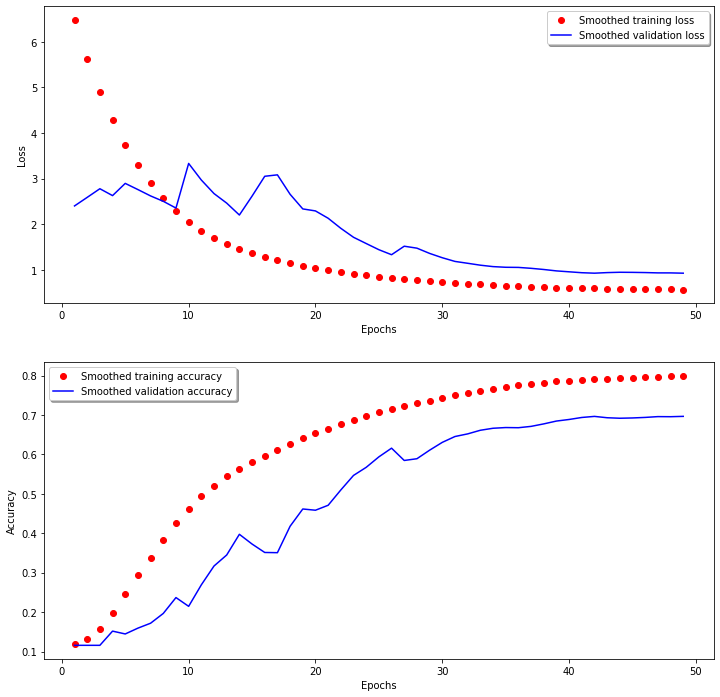

In [ ]:
plot_smoothed_learning_curves(history)

# predict
---
test data: 2000개

In [ ]:
pred =model.predict(xtest)
pred = np.argmax(pred, axis=1)
print(pred[0:30])
print(y_test[0:30])
count = 0
for i in pred:
    if pred[i] != y_test[i]:
        count += 1
print('total-predict:',len(y_test),'\nCorrect-predict:',len(y_test)-count,'\nWrong-predict:',count)

[7 7 2 3 1 1 0 0 4 2 1 1 4 7 9 1 5 7 9 9 7 0 6 8 9 4 0 0 1 1]
[7 7 2 2 1 1 0 0 4 4 1 1 4 4 9 9 5 5 9 9 0 0 6 6 9 9 0 0 1 1]
total-predict: 2000 
Correct-predict: 1633 
Wrong-predict: 367


# confusion matrix
---

accuracy score: 0.7275


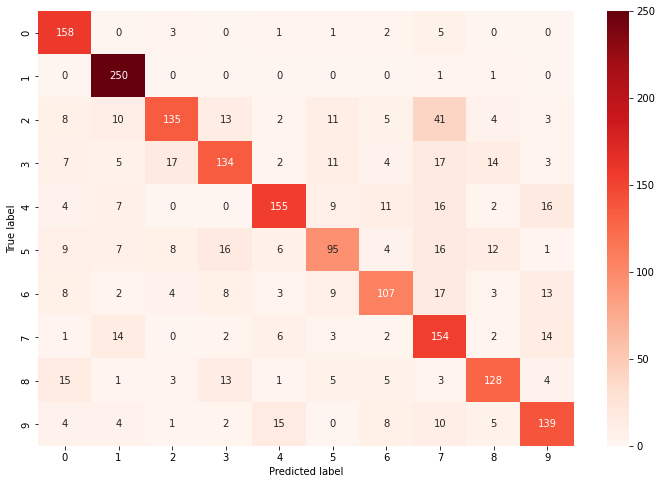

In [ ]:
def plot_confusion_matrix(model_name):
    # Predict 
    y_pred = model_name.predict(xtest)

    # Y_pred는 각 확률값을 나타내므로 max 확률로 선택 
    y_pred = np.argmax(y_pred,axis = 1)
    
    #accuracy scores
    print('accuracy score:', accuracy_score(y_test,y_pred))
    
    # confusion matrix 설정
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, index = range(10), columns = range(10))

    # confusion matrix 시각화
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, cmap="Reds", annot=True, fmt='.0f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

plot_confusion_matrix(model)

# 이미지 불러오기
---

In [ ]:
with h5py.File('../Kaggle/3D_MNIST/full_dataset_vectors.h5', "r") as hf:    
    # Split the data into training/test features/targets
    x_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    x_test = hf["X_test"][:] 
    y_test = hf["y_test"][:]

In [ ]:
## 데이터셋 channel 추가 
x_train = np.ndarray((x_train.shape[0], 4096, 3))
x_test = np.ndarray((x_test.shape[0], 4096, 3))

In [ ]:
## 데이터셋 channel 추가 
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

# rgb
def add_rgb_dimention(array):
    scalar_map = cm.ScalarMappable(cmap="Oranges")
    return scalar_map.to_rgba(array)[:, : -1]

## rgb 추가
for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

7


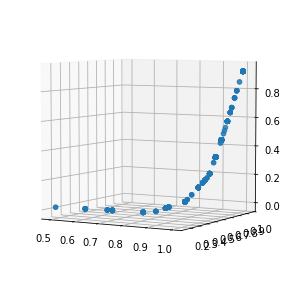

In [ ]:
print(y_test[0])

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax0 = fig.add_subplot(111, projection="3d")

idx = 0
x = xtrain[idx][:,0]
y = xtrain[idx][:,1]
z = xtrain[idx][:,2]

ax0.view_init(5, -60)
#ax0.view_init(0, 0)
ax0.scatter(x,y,z)

In [ ]:
x.shape, y.shape, z.shape

((4096,), (4096,), (4096,))

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('file1.py','wb').write(src)
import file1

Saving plot3D.py to plot3D.py


In [ ]:
x_train[0].shape

(4096,)

In [ ]:
file1.plot_points(x_train[0])

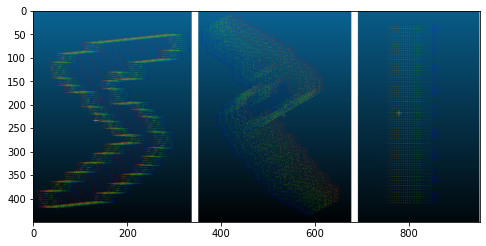

In [ ]:
plt.figure(figsize=(8,8))
img_3d = plt.imread('./3dmnist.png')
plt.imshow(img_3d)
plt.show()

In [ ]:
# #Load the best weights:
# model.load_weights('best_weight.h5')